In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from pathlib import Path
from numpy import mean
from numpy import std
from numpy import cov
from scipy.stats import pearsonr
import requests
import urllib.request
import json
import pprint
from dotenv import load_dotenv
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

load_dotenv()
access_token = os.getenv("CQ_API_KEY")
headers = { 'Authorization': 'Bearer ' + access_token }

In [65]:
def get_netflow_data(ticker,fromdate,limit):
    '''
    Returns on-chain data (Netflow)n in new df
        Parameters:
            ticker (string) = Ticker for Desired Coin
            fromdate (string) = Starting date of period desired
            limit (int) = number of data points     
    '''
    #Initialize dotenv function, pull API key, build URL
    headers = {'Authorization': 'Bearer ' + access_token}
    URL = f'https://api.cryptoquant.com/v1/{ticker}/exchange-flows/netflow?exchange=all_exchange&window=day&from={fromdate}&limit={limit}'

    # Initialize Dictionary
    response = requests.get(URL, headers=headers)
    
    netflow_data = response.json()

    #Transform to Dataframe and adjust data type
    netflow_df = pd.DataFrame(data=netflow_data['result']['data'])
    netflow_df['date'] = pd.to_datetime(netflow_df['date'])
    netflow_df['netflow_total'] = netflow_df['netflow_total'].astype(str).astype('float64')
   
    return netflow_df


In [66]:
netflow_btc_df = get_netflow_data("btc","20190101","100")
netflow_btc_df.head(5)

,date,netflow_total
0,2021-01-29,17413.018375
1,2021-01-28,-6092.090538
2,2021-01-27,-10347.658278
3,2021-01-26,-2644.317802
4,2021-01-25,4471.674033


In [67]:
def get_price_data(ticker,fromdate,limit):
    '''
    Returns market data (ticker) in new df
        Parameters:
            ticker (string) = Ticker for Desired Coin
            fromdate (string) = Starting date of period desired
            limit (int) = number of data points     
    '''
    #Get Data & Initialize Dictionary
    URL2 = f'https://api.cryptoquant.com/v1/{ticker}/market-data/price-usd?window=day&from={fromdate}&limit={limit}'
    response2 = requests.get(URL2, headers=headers)
    price_data = response2.json()
    
    #Transform to Dataframe and adjust data type
    price_df = pd.DataFrame(data=price_data['result']['data'])
    price_df = price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    price_df['date'] = pd.to_datetime(price_df['date'])
    price_df['price_usd_close'] = price_df['price_usd_close'].astype(str).astype('float64')
    price_df = price_df.dropna()

    return price_df

In [68]:
price_btc_df = get_price_data("btc","20190101","100")
price_btc_df.head(5)

,date,price_usd_close
0,2021-01-29,34244.506667
1,2021-01-28,33383.746667
2,2021-01-27,30385.111667
3,2021-01-26,32489.385000
4,2021-01-25,32254.145000


In [69]:
def get_mvrv_data(ticker,fromdate,limit):
    '''
    Returns marketcap data in new df
        Parameters:
            ticker (string) = Ticker for Desired Coin
            fromdate (string) = Starting date of period desired
            limit (int) = number of data points     
    '''
    #Get Data & Initialize Dictionary
    URL3 = f'https://api.cryptoquant.com/v1/{ticker}/market-data/capitalization?window=day&from={fromdate}&limit={limit}'
    response3 = requests.get(URL3, headers=headers)
    mvrv_data = response3.json()

    #Transform to Dataframe and adjust data type
    mvrv_data = pd.DataFrame(data=mvrv_data['result']['data'])
    mvrv_data['mvrv_score'] = (mvrv_data['market_cap']/mvrv_data['realized_cap'])
    mvrv_data['date'] = pd.to_datetime(mvrv_data['date'])
    mvrv_data = mvrv_data.sort_values(by=['date'],ascending=False)
    mvrv_data = mvrv_data.drop(['average_cap', 'delta_cap', 'market_cap','realized_cap','thermo_cap'], axis = 1)

    return mvrv_data

In [70]:
mvrv_btc_df = get_mvrv_data("btc","20190101","100")
mvrv_btc_df.head(5)

,date,mvrv_score
0,2021-01-29,2.635438
1,2021-01-28,2.591286
2,2021-01-27,2.367614
3,2021-01-26,2.544537
4,2021-01-25,2.527854


In [71]:
def get_pearsons_coefficient(series1,series2):
    ''' 
    Returns pearsons coefficient (int) between 2 dataframes columns.
    Parameters: 
        series1 (object): First series to compare
        series2 (object): Second series to compare
    '''
    #formula to calculate covariance
    covariance = cov(series1,series2)
    corr, _ = pearsonr(series1,series2)
    
    return corr

In [72]:
def get_plots(input_df):
    '''
    Returns plot of inputed data frame
        Parameters:
        input_df: consumes the output of df builder functions above
    '''
    
    data_plot= input_df.hvplot(x='date',figsize=(100,100), rot=90)
    return data_plot

In [73]:
mvrv_plot = get_plots(mvrv_btc_df)
mvrv_plot

:Curve   [date]   (mvrv_score)

In [74]:
netflow_plot = get_plots(netflow_btc_df)
netflow_plot

:Curve   [date]   (netflow_total)

In [75]:
price_df_plot = get_plots(price_btc_df)
price_df_plot

:Curve   [date]   (price_usd_close)

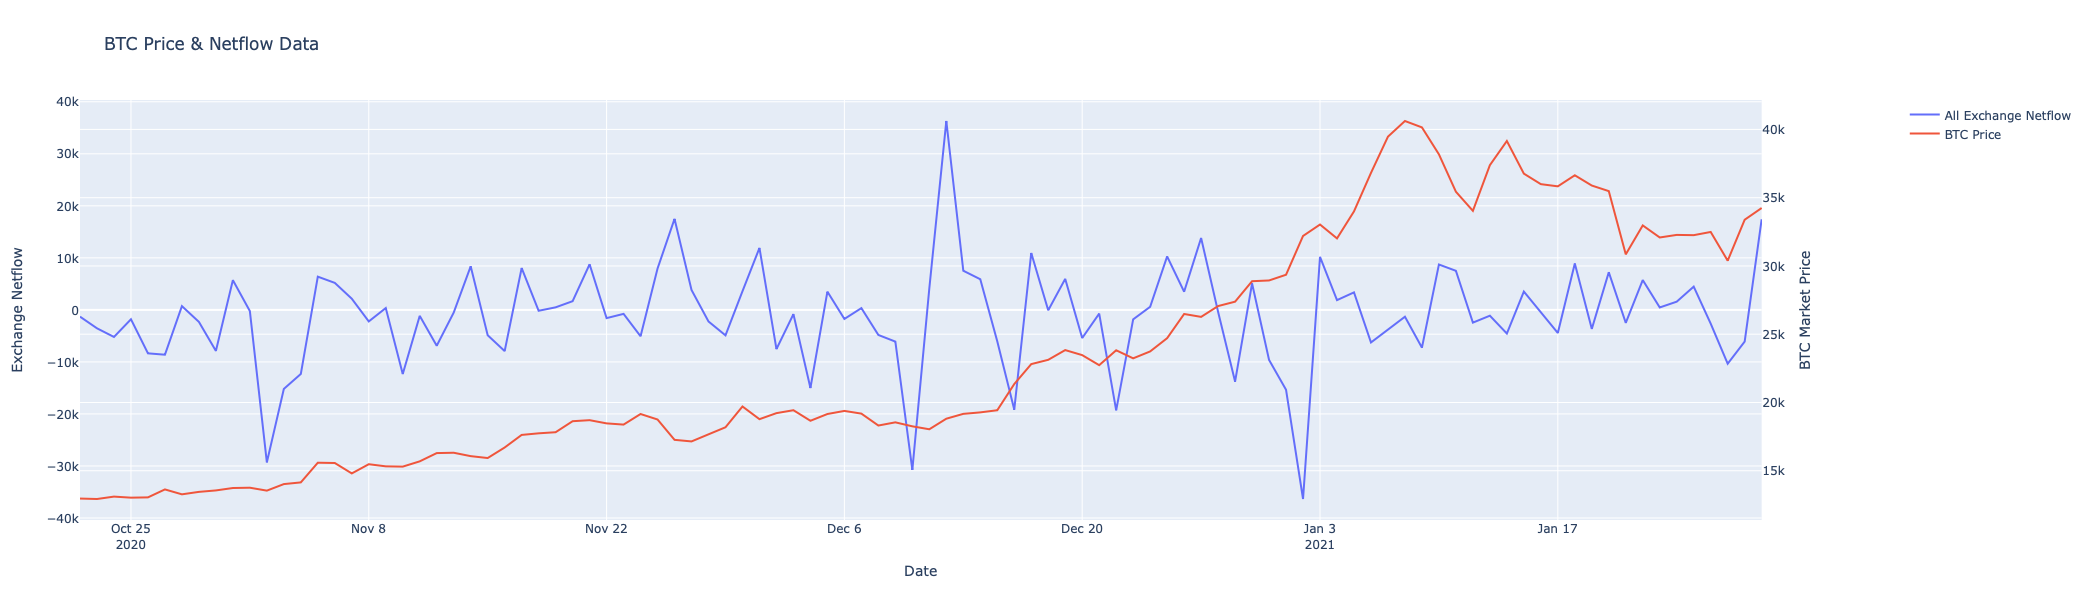

Pearsons Correlation of Netflow to Price: 0.07633298907264963


In [76]:

fig3 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig3.add_trace(
    go.Scatter(mode = 'lines',x=netflow_df['date'],y=netflow_df['netflow_total'], name = 'All Exchange Netflow'),
    secondary_y=False 
)

fig3.add_trace(
    go.Scatter(mode = 'lines',x=price_df['date'], y =price_df['price_usd_close'], name = 'BTC Price'),
    secondary_y=True 
)

fig3.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & Netflow Data'
)

fig3.update_xaxes(title_text = 'Date')

fig3.update_yaxes(title_text='Exchange Netflow', secondary_y= False)
fig3.update_yaxes(title_text='BTC Market Price', secondary_y= True)



fig3.show()
netflow_price_corr = get_pearsons_coefficient(netflow_btc_df['netflow_total'], price_btc_df['price_usd_close'])
print(f'Pearsons Correlation of Netflow to Price: {netflow_price_corr}')

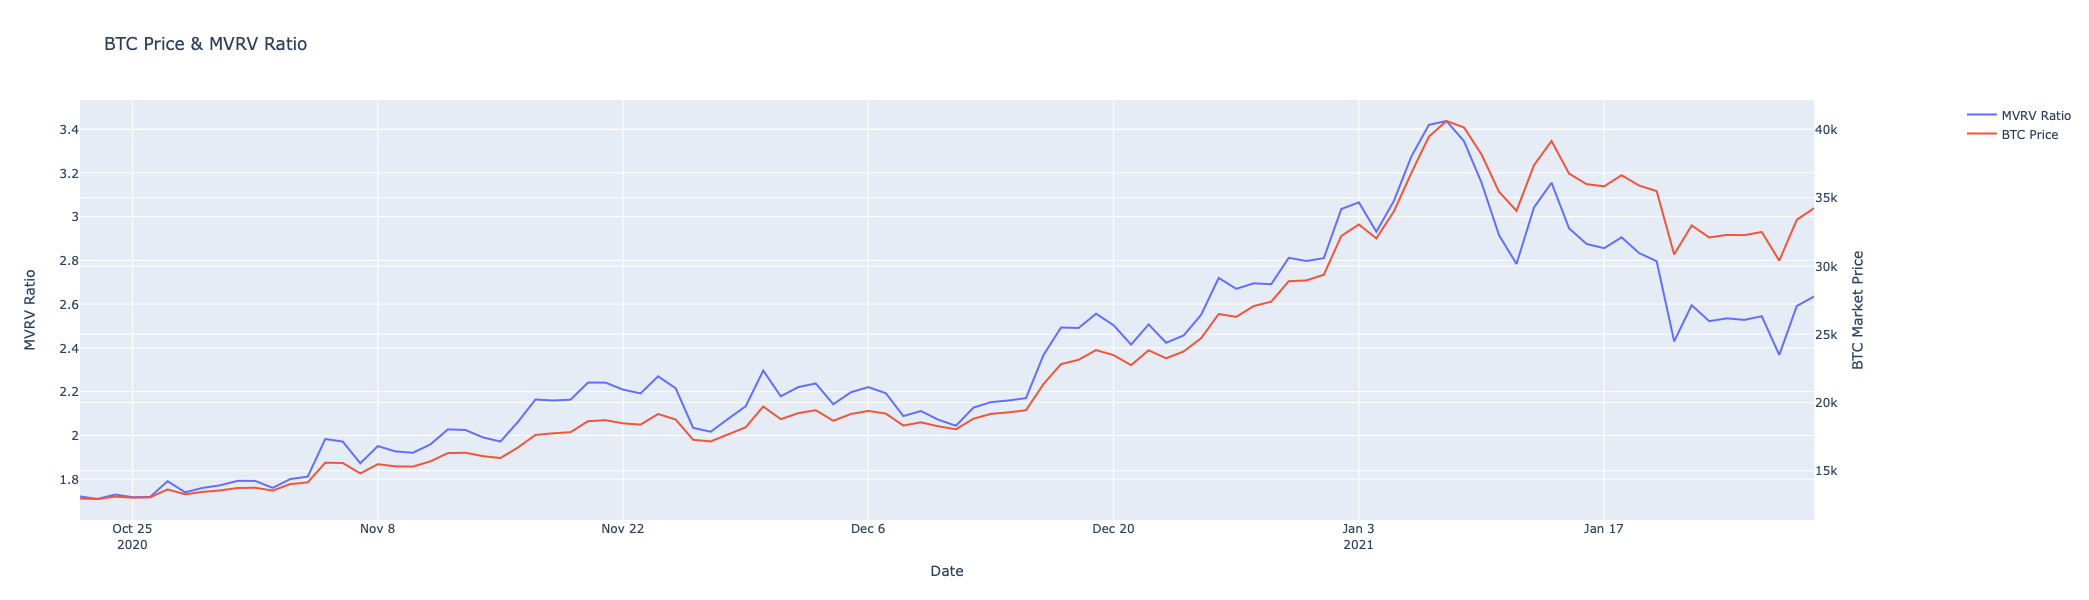

Pearsons Correlation of MVRV Score to Price: 0.9519341455994563


In [77]:

fig3 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig3.add_trace(
    go.Scatter(mode = 'lines',x=mvrv_btc_df['date'],y=mvrv_btc_df['mvrv_score'], name = 'MVRV Ratio'),
    secondary_y=False 
)

fig3.add_trace(
    go.Scatter(mode = 'lines',x=price_df['date'], y =price_df['price_usd_close'], name = 'BTC Price'),
    secondary_y=True 
)

fig3.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & MVRV Ratio'
)

fig3.update_xaxes(title_text = 'Date')

fig3.update_yaxes(title_text='MVRV Ratio', secondary_y= False)
fig3.update_yaxes(title_text='BTC Market Price', secondary_y= True)



fig3.show()

mvrc_price_corr = get_pearsons_coefficient(mvrv_btc_df['mvrv_score'], price_btc_df['price_usd_close'])
print(f'Pearsons Correlation of MVRV Score to Price: {mvrc_price_corr}')